In [1]:
from classes import *
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle

In [2]:
#Load the experiments
input_path = "temp/experiments/experiment_2020_8_25.p"
output_path = os.path.dirname(input_path)
experiments = pickle.load( open( input_path, "rb" ) )
experiments

[Rotty_Bamber_2019_high_95__5_R. Active 2020/08/25, 15:30:45,
 Rotty_SROCC_2019_RCP26_17__5_R. Active 2020/08/25, 15:30:46,
 Rotty_SROCC_2019_RCP85_50__5_R. Active 2020/08/25, 15:30:46,
 Rotty_SROCC_2019_RCP85_83__5_R. Active 2020/08/25, 15:30:46]

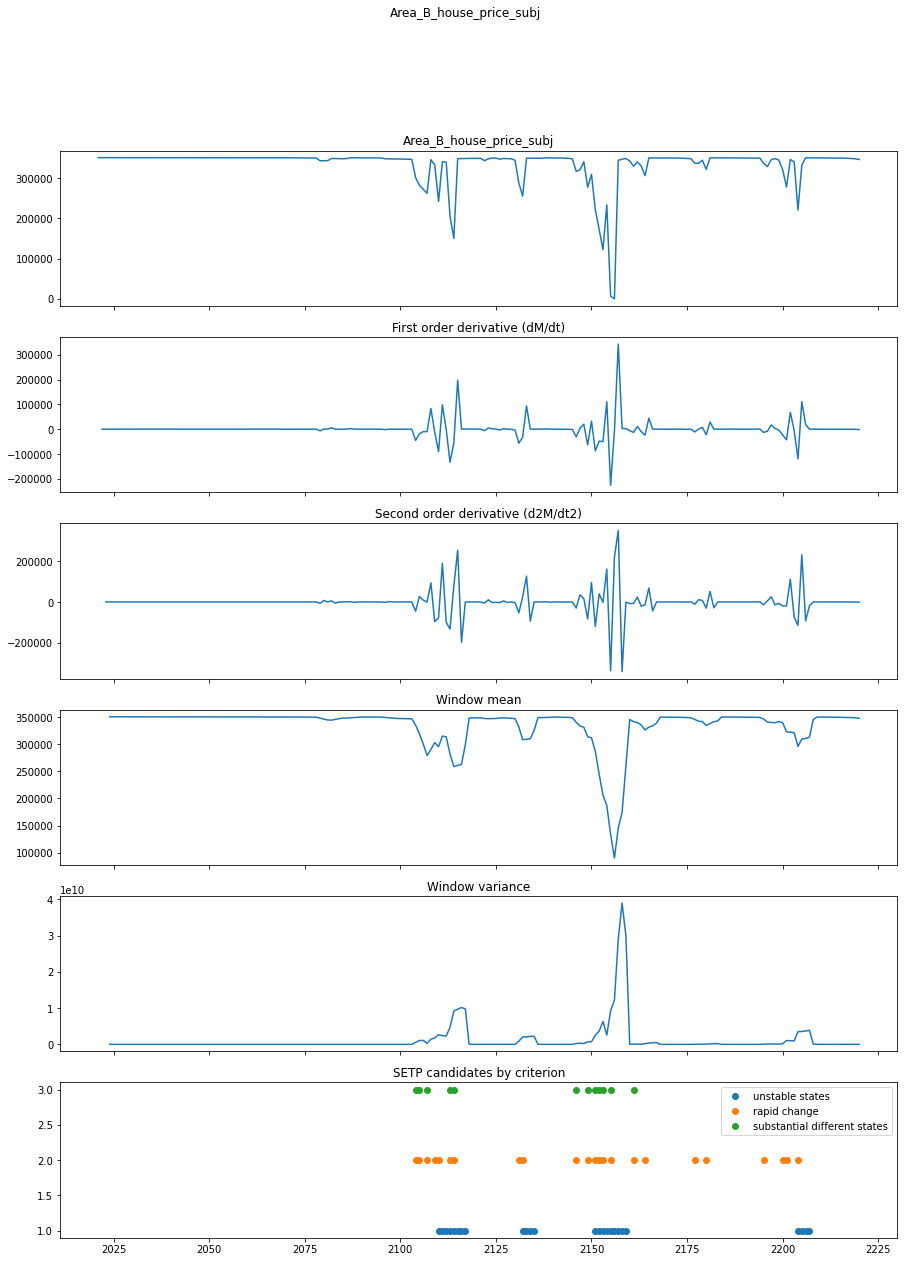

In [5]:
experiment = experiments[0]
experiment.create_Metrics()
for M in experiment.allMetrics:
    M.create_statistics()
M.select_candidates()    
M.plot_both(figsize=(15,20))